#### TMA4205 Numerical Linear Algebra
# Project Part 1

In [50]:
# imports and useful functions
import numpy as np
import matplotlib.pyplot as plt
from linalg.convergence import *

## Exercise 1:

introduction


### Implementation of cg:

In [51]:
from linalg.iterative import cg

We define the test case for problem 1

In [52]:
from test.case_one import CaseOne
from linalg.laplacian import minus_laplace

Plot solutions for 3 grid sizes $N \in [3, 64, 128]$

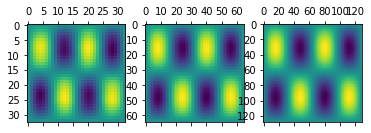

In [53]:
N_list = [32, 64, 128]
fig, axs = plt.subplots(1, len(N_list))
for i, N in enumerate(N_list):
    rhs = CaseOne.get_rhs(N)
    U_0 = CaseOne.get_u_0(N)
    U_num = cg(A=minus_laplace, x_0=U_0,rhs=rhs, N=N, tol=1e-12, maxiter=2000)
    axs[i].matshow( U_num)

